In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import traceback

In [54]:
target_names = ['person', 'laptop', 'chair', 'tvmonitor', 'diningtable']

In [123]:
class YOLOV3:
    def __init__(self, targets):
        self.objects = {name:[] for name in targets} # {target_name:[(id, box, center)]}
        self.prev_objects = None # assign previos frame's ojects later in code
        self.target_names = targets
        self.net, self.output_layers, self.classes, self.targets = self.load_yolo(self.target_names)
        
    def load_yolo(self, targets):
        # Load Yolo
        net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        with open("coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]
        targets = np.array([np.where(np.array(classes) == target) for target in target_names]).flatten() # find index of wanted targets
        #print(targets)
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        
        return net, output_layers, classes, targets

    def detect_objects(self, size=(320,320), swapRB=True, crop=False, scalefactor=0.00392):
        # Detecting objects
        blob = cv2.dnn.blobFromImage(self.img, scalefactor, size, (0, 0, 0), swapRB, crop=crop)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)
    
        self.outs = outs
    
    # Showing informations on the screen
    def find_indexes(self, conf=0.9):
        self.class_ids = []
        self.confidences = []
        self.boxes = []
        self.centers = []
        dims = self.img.shape
        for out in self.outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > conf and class_id in self.targets:
                    # Object detected
                    center_x = int(detection[0] * dims[1])
                    center_y = int(detection[1] * dims[0])
                    w = int(detection[2] * dims[1])
                    h = int(detection[3] * dims[0])

                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    self.boxes.append([x, y, w, h])
                    self.centers.append((center_x, center_y))
                    self.confidences.append(float(confidence))
                    self.class_ids.append(class_id)

        self.indexes = cv2.dnn.NMSBoxes(self.boxes, self.confidences, 0.5, 0.4) # non max suppression
        
    def find_NMS_boxes(self):
        self.prev_objects = self.objects # set previous objects before resetting
        self.objects = {name:[] for name in self.target_names} # clear 'prev' objects
        try:
            for i in self.indexes:
                label = str(self.classes[self.class_ids[i[0]]])
                box = self.boxes[i[0]]
                center = self.centers[i[0]]
                self.objects[label].append((i[0], box, center)) # {target_name:[(id, [box], (center)]}
            
            print(self.objects)
        except KeyError:
            print('key '+ label + 'not found')
        
    def draw_boxes_labels(self, colors=(0,255,0)):
        font = cv2.FONT_HERSHEY_PLAIN
        height, width, dim = self.img.shape
        rect_thicc = int(height/70)
        if height < 70:
            rect_thicc = 1
        self.find_NMS_boxes()
        for label in self.target_names:
            for obj in self.objects[label]:   
                x, y, w, h = obj[1] # obj[1] = box
                font_size = int(height/300)+1
                font_width = int(height/200)+1
                lbl = label
                color = colors
                cv2.rectangle(self.img, (x, y), (x + w, y + h), color, rect_thicc)
                cv2.circle(self.img, obj[2], rect_thicc*2, (0,255,0), thickness=rect_thicc)
                cv2.putText(self.img, lbl + ' ' + str(obj[0]), (x, y - font_size), font, font_size, color, font_width)
                
                
    def yolo_frame(self, img):
        img = cv2.resize(img, None, fx=0.4, fy=0.4) # resize image
        self.img = img
        self.detect_objects() # find all objects
        self.find_indexes(.7) # box object if object in targets
        self.draw_boxes_labels() # update frame
        return img
    
    def yolo_video(self, filename):
        cap=cv2.VideoCapture(filename)
        if cap.isOpened() == False: 
            print("Error opening video stream or file")
        t1 = time.time()
        try:
            while True:
                ret, img=cap.read()
                frame = cv2.resize(img, (768, 432)) 
                if time.time() - t1 > .6:
                    t = time.time()
                    img = self.yolo_frame(img)
                    print(time.time() - t)
                    #open final window
                    cv2.imshow('img', img)
                    t1 = time.time()
#             else:
#                 cv2.imshow('img', frame)
            #press q to quite the window
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
        except:
            traceback.print_exc() 
            print('video or camera feed ended')
            pass
        finally:
            cap.release()
            cv2.destroyAllWindows()

{'person': [], 'laptop': [], 'chair': [(13, [36, 92, 62, 66], (67, 125)), (9, [128, 83, 48, 63], (152, 115)), (6, [182, 78, 48, 60], (206, 108)), (7, [236, 81, 39, 48], (256, 105))], 'tvmonitor': [(4, [104, 56, 45, 28], (127, 70)), (1, [221, 51, 31, 24], (237, 63)), (2, [15, 57, 58, 33], (44, 74)), (0, [169, 53, 33, 25], (186, 66)), (17, [264, 49, 27, 21], (278, 60))], 'diningtable': []}
{'person': [(6, [414, 340, 64, 89], (446, 385)), (14, [192, 104, 33, 76], (209, 142)), (0, [23, 213, 41, 87], (44, 257)), (11, [541, 1, 24, 54], (553, 28)), (16, [115, 120, 31, 68], (131, 154)), (2, [631, 268, 37, 105], (650, 321)), (10, [515, -2, 25, 43], (528, 19)), (13, [534, 105, 33, 59], (551, 135)), (12, [217, 73, 20, 53], (227, 100)), (8, [464, 1, 14, 16], (471, 9))], 'laptop': [], 'chair': [], 'tvmonitor': [], 'diningtable': []}
0.6184206008911133
{'person': [(4, [643, 255, 47, 104], (667, 307)), (2, [48, 195, 41, 92], (69, 241)), (10, [197, 96, 34, 70], (214, 131)), (5, [449, 318, 53, 112], (4

{'person': [(23, [376, 124, 31, 80], (392, 164)), (6, [113, 173, 39, 90], (133, 218)), (5, [290, 164, 40, 95], (310, 212)), (28, [631, 182, 31, 53], (647, 209)), (10, [675, 216, 49, 94], (700, 263)), (27, [244, 160, 30, 93], (259, 207)), (25, [68, 165, 33, 67], (85, 199)), (16, [355, 49, 23, 59], (367, 79)), (19, [398, 57, 31, 61], (414, 88)), (15, [628, 26, 26, 50], (641, 51)), (1, [1, 144, 36, 94], (19, 191)), (14, [545, -4, 25, 54], (558, 23)), (18, [262, 71, 24, 43], (274, 93)), (24, [-3, 138, 19, 106], (6, 191)), (11, [418, -2, 25, 44], (431, 20)), (20, [681, 89, 32, 75], (697, 127)), (9, [613, 232, 46, 73], (636, 269))], 'laptop': [], 'chair': [], 'tvmonitor': [], 'diningtable': []}
0.5834507942199707
{'person': [(14, [393, 119, 30, 73], (408, 156)), (5, [140, 160, 42, 86], (161, 203)), (2, [28, 149, 47, 80], (52, 189)), (20, [267, 154, 31, 83], (283, 196)), (3, [80, 144, 40, 85], (100, 187)), (7, [680, 199, 50, 89], (705, 244)), (15, [0, 130, 29, 95], (14, 178)), (6, [313, 156, 

{'person': [(5, [539, 53, 25, 56], (552, 81)), (7, [473, 59, 28, 69], (487, 94)), (4, [364, 51, 30, 63], (379, 83)), (12, [705, 69, 32, 61], (721, 100)), (13, [206, 125, 30, 81], (221, 166)), (6, [439, 59, 28, 67], (453, 93)), (3, [619, 30, 21, 58], (630, 59)), (8, [200, 71, 27, 66], (214, 104)), (1, [448, 10, 27, 54], (462, 37)), (2, [349, 29, 19, 52], (359, 55)), (9, [247, 72, 27, 53], (261, 99))], 'laptop': [], 'chair': [], 'tvmonitor': [], 'diningtable': []}
0.5714621543884277
{'person': [(6, [376, 48, 25, 59], (389, 78)), (21, [662, 67, 28, 63], (676, 99)), (2, [611, 33, 25, 57], (624, 62)), (4, [548, 46, 22, 55], (559, 74)), (13, [483, 53, 27, 70], (497, 88)), (12, [451, 56, 26, 66], (464, 89)), (19, [214, 69, 28, 65], (228, 102)), (18, [181, 74, 26, 62], (194, 105)), (11, [267, 68, 23, 45], (279, 91)), (1, [464, 8, 20, 53], (474, 35)), (16, [700, 60, 30, 62], (715, 91)), (0, [173, 134, 43, 81], (195, 175)), (10, [246, 64, 23, 57], (258, 93))], 'laptop': [], 'chair': [], 'tvmonit

Traceback (most recent call last):
  File "<ipython-input-123-8b73ddc3938f>", line 109, in yolo_video
    frame = cv2.resize(img, (768, 432))
cv2.error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



video or camera feed ended


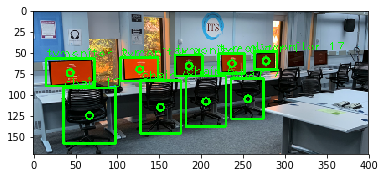

In [124]:
img = cv2.imread('Lab1.jpg')
YOLO = YOLOV3(target_names)
plt.imshow(YOLO.yolo_frame(img))
YOLO.yolo_video(filename='pedestrians.mp4')